# Compare axisymmetric versus spherical JAM with intrinsic shape distribution similar to the SLACS lens sample

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import csv

from copy import deepcopy

In [2]:
from deproject.Profiles.SIS_truncated_physical import SIS_truncated_physical
from deproject.Profiles.Jaffe import Jaffe
from deproject.Cosmo.default_cosmo import get_default_lens_cosmo
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_half_light_isophote import mge_half_light_isophote
from deproject.MGE_analysis.mge_proj import MGE_Proj
from deproject.MGE_analysis.intr_mge import Intr_MGE

from scipy.stats import truncnorm
from scipy.optimize import curve_fit

from hierarc.Util.distribution_util import PDFSampling


## Calculation

In [3]:
def qintr_prior(mu, sigma, num): # sample q_intr from truncated Gaussian prior
    lo_lim, hi_lim = 0, 1
    lo_transformed = (lo_lim - mu) / sigma
    hi_transformed = (hi_lim - mu) / sigma
    qintr_prior = truncnorm(lo_transformed, hi_transformed, loc = mu, scale = sigma)
    return qintr_prior.rvs(size = num)

def isotropic_inc(num):
    """sample random inclination angle

    Args:
        num (_type_): sample size

    Returns:
        _type_: random inclination angle [rad]
    """
    cos_i = np.random.uniform(0, 1, num)
    return np.arccos(cos_i)

def qobs_model(qintr, inc): 
    """calculate the projected axis ratio using axisymmatric projeciton formula

    Args:
        qintr (_type_): intrinsic axis ratio, qintr < 1
        inc (_type_): inclination angle [rad]

    Returns:
        _type_: projected axis ratio, qobs < 1
    """
    qobs = np.sqrt((qintr * np.sin(inc))**2 + np.cos(inc)**2)
    return qobs

def get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr, plot_mge=0, fignum=1):
    """get the amplitude and dispersion of the MGE describing the INTRINSIC mass density/stellar light profile along the symmetry axis 

    Args:
        sigma_v (_type_): sigma_sph of the truncated SIS profile
        rc_kpc (_type_): truncation radius in kpc
        r_sym (_type_): coordinate along the symmetry axis
        qintr (_type_): intrinsic axis ratio. If oblate, qintr < 1; if prolate, qintr > 1
        plot_mge (int, optional): _description_. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: amplitude in M_sun/pc^3
        _type_: dispersion in pc
    """
    sis_profile = SIS_truncated_physical(sigma_v=sigma_v, rc = rc_kpc)
    intr_mge = Intr_MGE(profile=sis_profile, qintr=qintr, r_sym=r_sym)
    peak, sigma = intr_mge.MGE_param(kwargs_mge={'ngauss': 20, 'inner_slope': 3, 'outer_slope':1}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    return peak, sigma

def get_jaffe_intr_mge(m_star, rs_kpc, qintr, plot_mge=0, fignum=1):
    """get the amplitude and dispersion of the MGE describing the INTRINSIC mass density/stellar light profile along the symmetry axis 

    Args:
        m_star (_type_): total stellar mass [M_sun]
        rs_kpc (_type_): scale radius in kpc
        qintr (_type_): intrinsic axis ratio. If oblate, qintr < 1; if prolate, qintr > 1
        plot_mge (int, optional): _description_. Defaults to 0.
        fignum (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: amplitude in M_sun/pc^3
        _type_: dispersion in pc
    """
    jaffe_profile = Jaffe(rs=rs_kpc, rho0=1e5)

    r_sym = np.geomspace(0.001, 10 * rs_kpc, 300)

    intr_mge = Intr_MGE(profile=jaffe_profile, qintr=qintr, r_sym=r_sym)

    peak, sigma = intr_mge.MGE_param(kwargs_mge = {'ngauss': 20}, plot_mge=plot_mge, fignum=fignum)

    peak = peak / 1e9 # convert to [M_sun/pc^3]
    sigma = sigma * 1e3 # convert to [pc]

    mtot = intr_mge.MGE_mass_sph()
    peak = m_star / mtot * peak # rescale to desired input stellar mass

    return peak, sigma


def get_proj_mge(mge_proj, distance, inc):
    """get projected MGE

    Args:
        mge_proj (_type_): MGE_proj instance
        distance (_type_): angular diameter distance in Mpc, used to convert the dispersion to arcsec
        inc (_type_): inclination angle [rad]

    Returns:
        _type_: peak of the projected MGE [M_sun/pc^3]
        _type_: sigma of the projected MGE [arcsec]
        _type_: projected axis ratio 
    """
    surf = mge_proj.surf(inc=inc)
    qobs = mge_proj.qobs(inc=inc)

    qobs = np.full_like(surf, qobs)

    pc = distance * np.pi / 0.648
    sigma_intr = mge_proj.sigma
    sigma = sigma_intr / pc

    return surf, sigma, qobs

def get_sigma_e(surf_lum, sigma_lum, qobs_lum, jam, xbin, ybin):

    ifu_dim = int(np.sqrt(len(xbin)))
    if np.all(qobs_lum <= 1):
        flux = jam.flux
        reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, qobs_lum)
    elif np.all(qobs_lum > 1):
        flux = np.reshape(jam.flux, (ifu_dim, ifu_dim)).T 
        flux = flux.flatten()
        reff, reff_maj, eps_e, lum_tot = mge_half_light_isophote(surf_lum, sigma_lum, 1/qobs_lum)
    else:
        raise ValueError('Apparent axis ratio must be constant with radius!')

    w = xbin**2 + (ybin/(1 - eps_e))**2 < reff_maj**2

    model = jam.model

    sig_e = np.sqrt((flux[w]*model[w]**2).sum()/flux[w].sum())

    print('sigma_e = {:.2f} km/s' .format(sig_e))

    return sig_e

def sphericalize_2d(sigma_proj, qobs):
    """sphericalize MGE by rescaling the sigma 

    Args:
        sigma_proj (_type_): sigma of the projected MGE along the symmetry axis
        qobs (_type_): observed axis ratio

    Returns:
        _type_: sphericalized sigma of the projected MGE
    """
    return sigma_proj * np.sqrt(qobs)

In [4]:
def get_sigma_e_dist(num, beta_const, oblate = True):
    """get predicted velocity dispersion under isotropic inclination angle assumption

    Args:
        num (_type_): number of projections
        beta_const (_type_): value of constant anisotropy
        oblate (bool, optional): shape is oblate or prolate. Defaults to True.

    Returns:
        _type_: _description_
    """
    sigma_e_axi_all = np.zeros(num)
    sigma_e_sph_all = np.zeros(num)

    if oblate:
        mu_qintr_sr, sigma_qintr_sr = 0.74, 0.08 # intrinsic axis ratio prior from Li et al 2018
    else: 
        mu_qintr_sr, sigma_qintr_sr = 0.84, 0.04 # deduced from Li et al 2018

    qintr_all = qintr_prior(mu_qintr_sr, sigma_qintr_sr, num)
    inc_all = isotropic_inc(num)
    qobs_model_all = qobs_model(qintr_all, inc_all)

    if not oblate:
        qintr_all = 1/qintr_all
        qobs_model_all = 1/qobs_model_all

    sigma_v = 200
    lens_cosmo = get_default_lens_cosmo()
    distance = lens_cosmo.Dd
    theta_sis = lens_cosmo.sis_sigma_v2theta_E(sigma_v)
    rc_kpc = lens_cosmo.arcsec2Mpc_lens(theta_sis) * 1e3 * 200
    r_sym = np.geomspace(0.01, 5 * rc_kpc, 300)

    m_star = 1e11
    rs_kpc = 7.5 / 0.763 # rs = Re / 0.763

    xx = np.linspace(-5 * theta_sis, 5 * theta_sis, 100)  # avoid (x,y)=(0,0)
    xbin, ybin = map(np.ravel, np.meshgrid(xx, xx))

    for i in range(num):

        qintr = qintr_all[i]
        inc = inc_all[i]
        qobs_model_i = qobs_model_all[i]

        # intrinsic density mge and projection
        peak_den_3d, sigma_den_3d = get_truncsis_intr_mge(sigma_v, rc_kpc, r_sym, qintr) # get intrinsic MGE
        mge_proj_den = MGE_Proj(peak_den_3d, sigma_den_3d, qintr)
        peak_den_2d, sigma_den_2d, qobs_den = get_proj_mge(mge_proj_den, distance, inc) # project MGE
        sigma_den_2d_sph = sphericalize_2d(sigma_den_2d, qobs_model_i) # sphericalize in 2d

        # intrinsic light mge and projection
        peak_lum_3d, sigma_lum_3d = get_jaffe_intr_mge(m_star, rs_kpc, qintr)
        mge_proj_lum = MGE_Proj(peak_lum_3d, sigma_lum_3d, qintr)
        peak_lum_2d, sigma_lum_2d, qobs_lum = get_proj_mge(mge_proj_lum, distance, inc)
        sigma_lum_2d_sph = sphericalize_2d(sigma_lum_2d, qobs_model_i) # sphericalize in 2d

        beta = np.ones_like(peak_lum_3d) * beta_const

        # axisymmetric 
        jam = jam_axi_proj(peak_lum_2d, sigma_lum_2d, qobs_lum, peak_den_2d, sigma_den_2d, qobs_den, np.degrees(inc), 0, distance, xbin, ybin, align='sph', beta=beta)  
        sigma_e_axi = get_sigma_e(peak_lum_2d, sigma_lum_2d, qobs_lum, jam, xbin, ybin)
        sigma_e_axi_all[i] = sigma_e_axi

        # sphericalized in 2d
        jam_sph = jam_axi_proj(peak_lum_2d, sigma_lum_2d_sph, np.ones_like(peak_lum_2d), peak_den_2d, sigma_den_2d_sph, np.ones_like(peak_den_2d), np.degrees(inc), 0, distance, xbin, ybin, align='sph', beta=beta) 
        sigma_e_sph = get_sigma_e(peak_lum_2d, sigma_lum_2d_sph, np.ones_like(peak_lum_2d), jam_sph, xbin, ybin)
        sigma_e_sph_all[i] = sigma_e_sph

    return np.vstack([sigma_e_axi_all, sigma_e_sph_all, inc_all, qintr_all, qobs_model_all])

In [5]:
rerun_calculation = False

oblate = False
if oblate:
    oblate_name = 'oblate'
else:
    oblate_name = 'prolate'

beta_const_list = [-0.2, 0, 0.2]
num_proj = 2500

if rerun_calculation: # run calculation and write to file
    data_all = []
    for i, beta in enumerate(beta_const_list):
        data = get_sigma_e_dist(num_proj, beta, oblate)
        np.save('./beta_{}_' .format(i) + oblate_name + '.npy' , data)
        data_all.append(data)
else: # if not rerun calculation, load previously saved data
    data_all = [np.load('./beta_{}_' .format(i) + oblate_name + '.npy') for i in range(len(beta_const_list))]

if not oblate:
    for data_i in data_all:
        data_i[3] = 1/data_i[3]
        data_i[4] = 1/data_i[4]

### Corner plot for each anisotropy

In [6]:
import corner

def corner_plot(data):

    data_plot = deepcopy(data)
    data_plot[2] = np.degrees(data_plot[2])

    hist2dkwargs = {'plot_density':False, 'plot_contours':True, 'plot_datapoints': True, 'color': 'deepskyblue', 'data_kwargs': {'ms': 5, 'alpha': 0.3}}

    fig = corner.corner(data_plot.T, labels = [r'$\sigma_{\mathrm{axi}}^P$ [km/s]', r'$\sigma_{\mathrm{sph}}^P$ [km/s]', '$i$ [deg]', '$q$', "$q'$"], **hist2dkwargs, hist_kwargs = {'density': True, 'linewidth': 2}, label_kwargs={'fontsize': 20})

    for i, ax in enumerate(fig.get_axes()):
        ax.tick_params(axis='both', labelsize=14)
        if i == 0:
            mean_sigma = np.mean(data_plot[0])
            ax.axvline(mean_sigma, color = 'deepskyblue', ls = '--', lw = 2)
            ax.set_title(r'$\langle \sigma^P \rangle$ = {:.2f}' .format(mean_sigma), size = 18)
            # ax.text(0.0, 0.7, r'$\langle \sigma_e \rangle$ = {:.2f}' .format(mean_sigma), transform = ax.transAxes, size = 16)
        if i == 6:
            mean_sigma = np.mean(data_plot[1])
            ax.axvline(mean_sigma, color = 'deepskyblue', ls = '--', lw = 2)
            ax.set_title(r'$\langle \sigma^P \rangle$ = {:.2f}' .format(mean_sigma), size = 18)
       
    plt.plot([], [], lw = 2, ls = '-', color = 'deepskyblue', label = 'random projection')
    plt.plot([], [], label = 'mean velocity dispersion', ls = '--', lw = 2, color = 'deepskyblue')
    # plt.plot([], [], label = 'SLACS from Knabel et al. (2024)', lw = 2, ls = '-', color = 'sandybrown')

    fig.legend(bbox_to_anchor=(0., 0.9, 0.95 ,0), fontsize=18, frameon=False)
    
    return fig

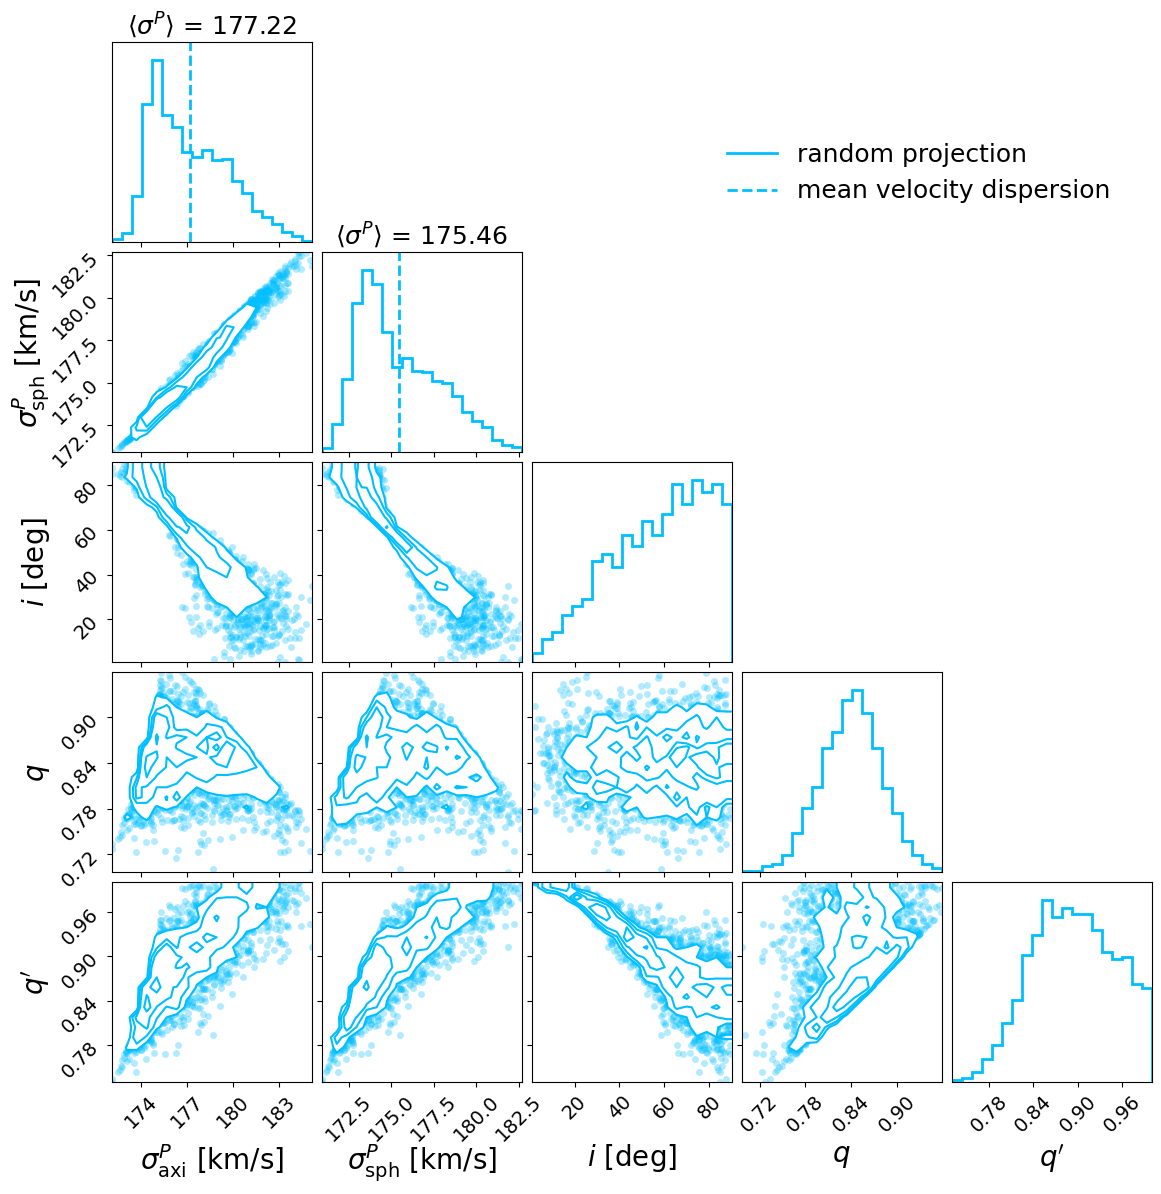

In [7]:
fig = corner_plot(data_all[1])
# plt.savefig('./corner_plot_beta_0_{}.pdf' .format(oblate_name), dpi=300, bbox_inches='tight')

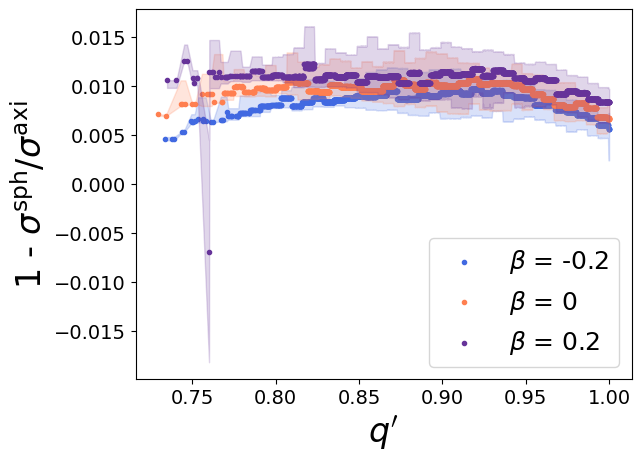

In [8]:
# plot the bias as a function of projected axis ratio
def bias_vs_qobs(sigma_axi, sigma_sph, qobs_model, qobs_measurement_list):
    """calculate the bias between axisymmetric and spherical JAM conditioned on the projected axis ratio

    Args:
        sigma_axi (_type_): veloity dispersion modeled with axisymmetric JAM
        sigma_sph (_type_): veloity dispersion modeled with spherical JAM
        qobs_model (_type_): projected axis ratio corresponding to each velocity dispersion model
        qobs_measurement_list (_type_): list of measured velocity dispersion (values on which the bias is conditioned)

    Returns:
        _type_: _description_
    """
    counts, bins = np.histogram(qobs_model, bins = 50, range = (qobs_model.min(), qobs_model.max() + 0.05))
    quantile = [0.16, 0.5, 0.84]
    pcs_list = []
    for qobs in qobs_measurement_list:
        bin_ind = np.digitize(qobs, bins) - 1 # find the qobs bin of the measured qobs
        bin_min, bin_max = bins[bin_ind], bins[bin_ind+1]
        real_ind = (qobs_model >= bin_min) & (qobs_model < bin_max) # retrieve the index of the velocity dispersions within the bin
        sigma_axi_binned = sigma_axi[real_ind]
        sigma_sph_binned = sigma_sph[real_ind]
        b = (sigma_axi_binned - sigma_sph_binned) / sigma_axi_binned # calculate the bias

        # calculate the median of the bias within the qobs bin
        b_counts_1d, bins_1d = np.histogram(b, bins = 30, density=True) 
        pdf_sampling = PDFSampling(bins_1d, b_counts_1d)
        b_draw = pdf_sampling.draw(100000)
        pcs = np.quantile(b_draw, q=quantile)
        pcs_list.append(pcs)
        
    return pcs_list

pcs_list_all = []

for i in range(len(beta_const_list)):
    sigma_e_axi_all, sigma_e_sph_all, inc_all, qintr_all, qobs_model_all = data_all[i]
    pcs_list_all.append(bias_vs_qobs(sigma_e_axi_all, sigma_e_sph_all, qobs_model_all, qobs_model_all))

plt.figure()
color = ['royalblue', 'coral', 'rebeccapurple']
for i in range(3):
    b_med = np.array([x[1] for x in pcs_list_all[i]])
    b_low = np.array([x[0] for x in pcs_list_all[i]])
    b_hi = np.array([x[2] for x in pcs_list_all[i]])
    q_obs = data_all[i][-1]

    sorted_indices = np.argsort(q_obs)
    q_obs = q_obs[sorted_indices]
    b_med = b_med[sorted_indices]
    b_low = b_low[sorted_indices]
    b_hi = b_hi[sorted_indices]

    plt.scatter(q_obs, b_med, marker = '.', label = r'$\beta$ = {}' .format(beta_const_list[i]), color = color[i])
    plt.fill_between(q_obs, b_low, b_hi, alpha = 0.2, color = color[i])
plt.xlabel("$q'$", size = 24)
plt.ylabel(r'1 - $\sigma^\mathrm{sph} / \sigma^\mathrm{axi}$', size = 24)
plt.legend(prop = {'size': 18})
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig('./bias_axi_vs_sph_' + oblate_name + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## The intrinsic shape prior for the prolate galaxies

The intrinsic shape prior from [https://ui.adsabs.harvard.edu/abs/2018ApJ...863L..19L/abstract] is triaxial (4-th row in Table 1). In the following we sample the two axia ratios and take their mean to be the intrinsic axis ratio for axisymmetric prolate galaxies. From the following results, we take Gaussian prior for prolates: mu = 0.84, sigma = 0.04

Mean: 0.8385809737758113, Std Dev: 0.04260349483249877 from arithmetic mean
Mean: 0.8394656364134586, Std Dev: 0.043104601190903404 from geometric mean


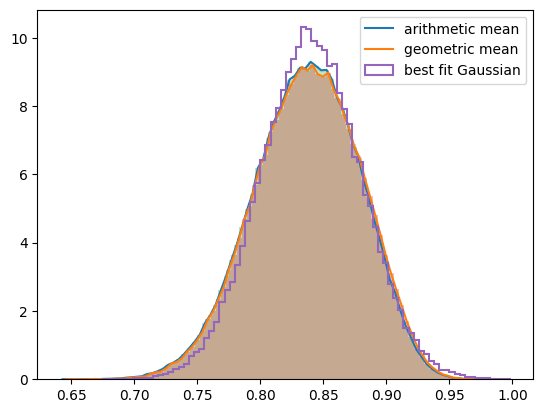

In [9]:
# for prolate, the intrinsic shape prior
mu_bovera, sigma_bovera = 0.86, 0.08
mu_covera, sigma_covera = 0.82, 0.04

N_sample = 300000
bovera_sample = qintr_prior(mu_bovera, sigma_bovera, N_sample)
covera_sample = qintr_prior(mu_covera, sigma_covera, N_sample)

arith_mean = (bovera_sample+covera_sample)/2.
geom_mean = np.hypot(bovera_sample, covera_sample)/np.sqrt(2.)

counts_arith, bin_edges_arith = np.histogram(arith_mean, bins=80, density=True)
counts_geom, bin_edges_geom = np.histogram(geom_mean, bins=80, density=True)

bin_centers_arith = (bin_edges_arith[:-1] + bin_edges_arith[1:]) / 2
bin_centers_geom = (bin_edges_geom[:-1] + bin_edges_geom[1:]) / 2

plt.plot(bin_centers_arith, counts_arith, marker = '', label = 'arithmetic mean')
plt.plot(bin_centers_geom, counts_geom, marker = '', label = 'geometric mean')

plt.hist(arith_mean, bins = 80, alpha=0.3, density=True)
plt.hist(geom_mean, bins = 80, alpha=0.3, density=True)

# fit a Gaussian to the distribution
def Gaussian(x, mean, std_dev):
    return (1 / (np.sqrt(2 * np.pi) * std_dev)) * np.exp(-((x - mean)**2) / (2 * std_dev**2))

# Fit the Gaussian
params_arith, cov_matrix_arith = curve_fit(Gaussian, bin_centers_arith, counts_arith, p0=[0.85, 0.05])
params_geom, cov_matrix_geom = curve_fit(Gaussian, bin_centers_geom, counts_geom, p0=[0.85, 0.05])


# Extract the parameters
print(f"Mean: {params_arith[0]}, Std Dev: {params_arith[1]} from arithmetic mean")
print(f"Mean: {params_geom[0]}, Std Dev: {params_geom[1]} from geometric mean")

qintr_test = qintr_prior(0.84, 0.04, 100000)
plt.hist(qintr_test, histtype='step', lw=1.5, bins = 80, density=True, label = 'best fit Gaussian')
plt.legend()
plt.show()